## Pilot Subjects Analysis

Dataset gathered from pilot subjects. All subjects were healthy adults. **TODO - ADD DESCRIPTION FOR PILOT SUBJECTS**



In [6]:
"""
Environment setup
"""
%matplotlib inline
%cd /lang_dec
import warnings; warnings.filterwarnings('ignore')
import hddm
import numpy as np
import matplotlib.pyplot as plt

from utils import model_tools

/Users/celefthe/Programming/projects/language_decision


In [11]:
# Import pilot subject data (as pandas dataframe)
pilot_data = hddm.load_csv('/lang_dec/data/pilot_clean.csv')

### Reaction Time & Accuracy 

Here we include the reaction time and accuracy metrics from the original dataset

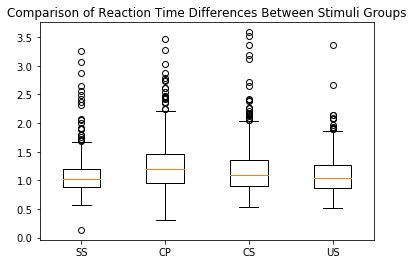

In [82]:
us = pilot_data.loc[pilot_data['stim'] == 'US']
ss = pilot_data.loc[pilot_data['stim'] == 'SS']
cp = pilot_data.loc[pilot_data['stim'] == 'CP']
cs = pilot_data.loc[pilot_data['stim'] == 'CS']

plt.boxplot([ss.rt.values, cp.rt.values, cs.rt.values, us.rt.values], 
            labels=('SS', 'CP', 'CS', 'US'),)
plt.title('Comparison of Reaction Time Differences Between Stimuli Groups')
plt.show()

In [83]:
ss_accuracy = (len([x for x in ss.response.values if x >= 1]) / len(ss.response.values)) * 100 
cp_accuracy = (len([x for x in cp.response.values if x >= 1]) / len(cp.response.values)) * 100
cs_accuracy = (len([x for x in cs.response.values if x >= 1]) / len(cs.response.values)) * 100
us_accuracy = (len([x for x in us.response.values if x >= 1]) / len(us.response.values)) * 100

print("SS Accuracy: " + str(ss_accuracy) + "%")
print("CP Accuracy: " + str(cp_accuracy) + "%")
print("CS Accuracy: " + str(cs_accuracy) + "%")
print("US Accuracy: " + str(us_accuracy) + "%")

SS Accuracy: 98.12108559498957%
CP Accuracy: 92.08333333333333%
CS Accuracy: 98.52941176470588%
US Accuracy: 99.37369519832986%


### Does the drift rate depend on stimulus type?

In [115]:
"""
Construct a model where the drift rate depends on the stimulus type
"""
pilot_model = hddm.HDDM(pilot_data, depends_on={'v': 'stim'})
pilot_model.find_starting_values()
pilot_model.sample(9000, burn=20, dbname='language_decision/models/pilot', db='txt')

 [-----------------100%-----------------] 9000 of 9000 complete in 405.4 sec

#### Convergence Checks

Before carrying on with analysing the output of the model, we need to check that the markov chains have properly converged. There's a number of ways to do this, which the authors of the `hddm` library recommend$^1$. We'll begin by visually inspecting the MCMC posterior plots. 

Plotting a
Plotting a_std
Plotting v(CP)
Plotting v(CS)
Plotting v(SS)
Plotting v(US)
Plotting v_std
Plotting t
Plotting t_std


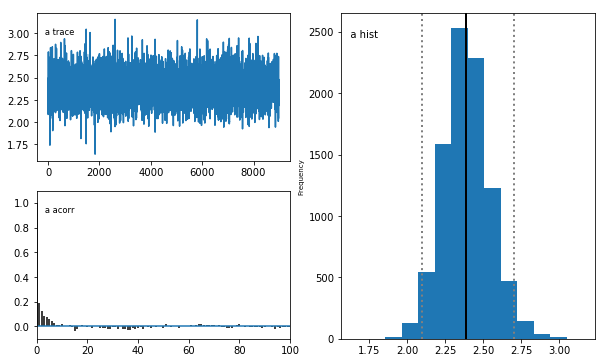

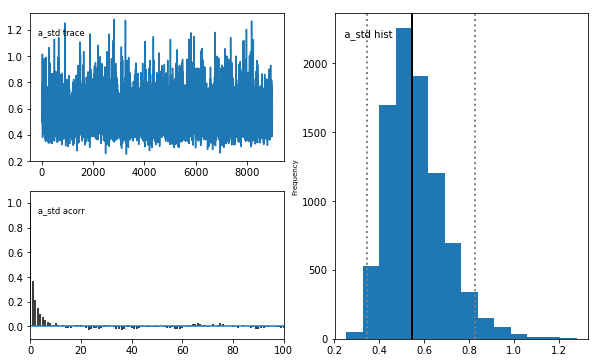

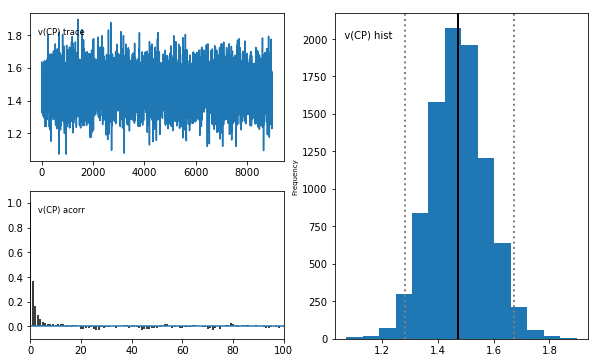

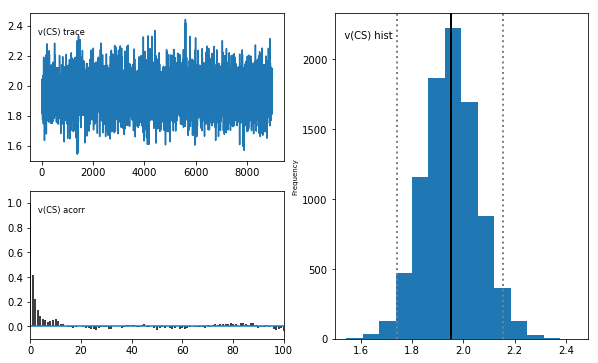

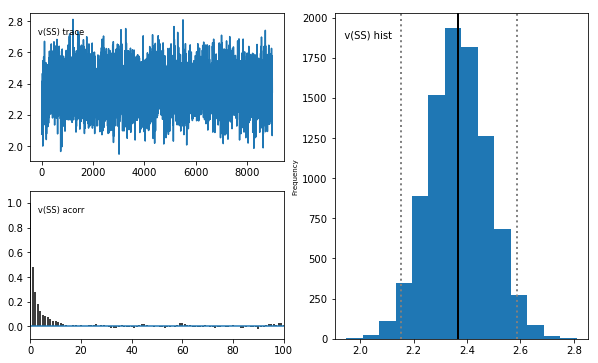

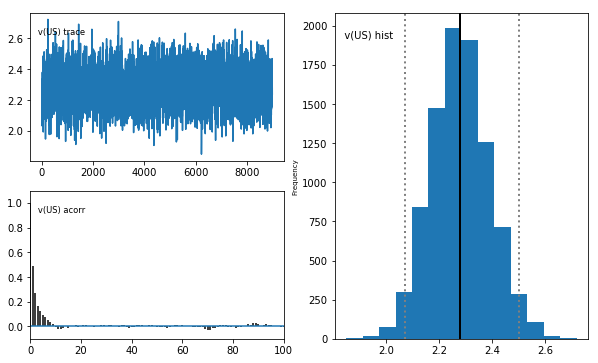

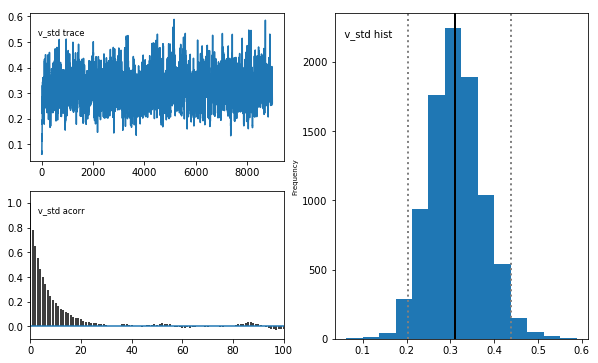

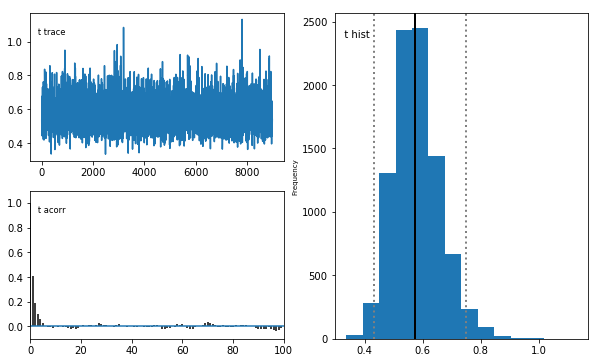

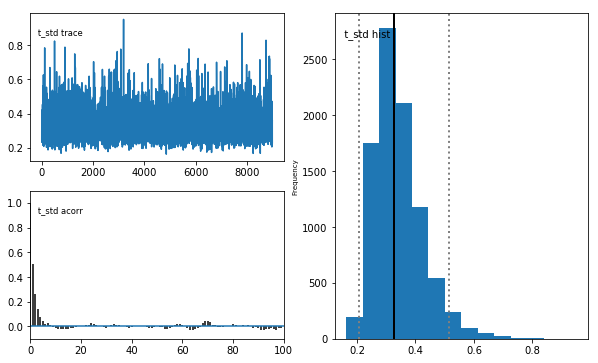

In [108]:
pilot_model.plot_posteriors()

**PASS** - No problematic patterns, such as drifts or large jumps, can be in any of the traces above. Autocorrelation also drops to zero quite quickly when considering past samples - which is what we want.

We can also formally test for model convergence using the Gelman-Rubin R statistic$^2$, which compares the within- and between-chain variance of different runs of the same model; models converge if variables are between $0.98$ and $1.02$. A simple algorithm to check this is outlined below:

In [109]:
models = []
for i in range(5):
    m = hddm.HDDM(pilot_data, depends_on={'v': 'stim'})
    m.find_starting_values()
    m.sample(6000, burn=20)
    models.append(m)

model_tools.check_convergence(models)

 [-----------------100%-----------------] 6000 of 6000 complete in 246.2 sec
No convergence problems detected!


True

**PASS** - Formal testing reveals no convergence problems; Gelman-Rubin R statistic values for all model variablesfall within the desired range ($0.98$ to $1.02$)

#### Drift Rate Analysis

Here, we examine whether the type of stimulus significantly affects the drift rate of the decision-making process.

In [110]:
pilot_stats = pilot_model.gen_stats()
print("Threshold (a) Mean: " + str(pilot_stats['mean']['a']) + " (std: " + str(pilot_stats['std']['a']) + ")")
print("Non-Decision (t) Mean: " + str(pilot_stats['mean']['t']) + " (std: " + str(pilot_stats['std']['t']) + ")")
print("SS Mean Drift Rate: " + str(pilot_stats['mean']['v(SS)']) + " (std: " + str(pilot_stats['std']['v(SS)']) + ")")
print("CP Mean Drift Rate: " + str(pilot_stats['mean']['v(CP)']) + " (std: " + str(pilot_stats['std']['v(CP)']) + ")")
print("CS Mean Drift Rate: " + str(pilot_stats['mean']['v(CS)']) + " (std: " + str(pilot_stats['std']['v(CS)']) + ")")
print("US Mean Drift Rate: " + str(pilot_stats['mean']['v(US)']) + " (std: " + str(pilot_stats['std']['v(US)']) + ")")

Threshold (a) Mean: 2.39053129375 (std: 0.153402870133)
Non-Decision (t) Mean: 0.579150538422 (std: 0.0815867063599)
SS Mean Drift Rate: 2.36964274266 (std: 0.111766969291)
CP Mean Drift Rate: 1.47437857405 (std: 0.100296796738)
CS Mean Drift Rate: 1.95221823439 (std: 0.105758067149)
US Mean Drift Rate: 2.28074632343 (std: 0.110277257251)


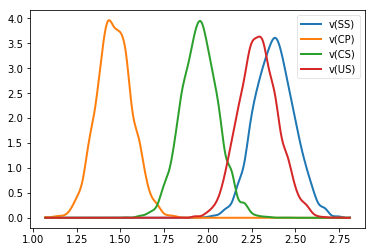

In [111]:
v_SS, v_CP, v_CS, v_US = pilot_model.nodes_db.node[['v(SS)', 'v(CP)', 'v(CS)', 'v(US)']]

hddm.analyze.plot_posterior_nodes([v_SS, v_CP, v_CS, v_US])

Estimating the model in a Bayesian framework allows us to test for significance directly on the posterior, rather than having to rely on conventional frequency statistical tests:

In [112]:
print('P(SS > US) = ' + str((v_SS.trace() > v_US.trace()).mean()))
print('P(CP > SS) = ' + str((v_CP.trace() > v_SS.trace()).mean()))
print('P(CS > SS) = ' + str((v_CS.trace() > v_SS.trace()).mean()))
print('P(CP > CS) = ' + str((v_CP.trace() > v_CS.trace()).mean()))

P(SS > US) = 0.729621380846
P(CP > SS) = 0.0
P(CS > SS) = 0.00244988864143
P(CP > CS) = 0.00022271714922


- The drift rate for **CP** is significantly lower than all other conditions  
- The drift rate for **CS** is significantly lower than **SS** and **US**, but significantly higher than **CP**  
- The drift rates for **SS** and **US** are not significantly different  

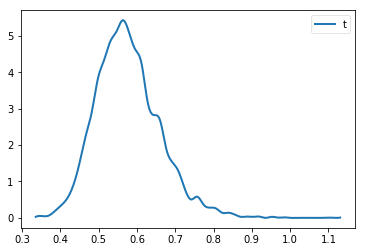

In [114]:
"""
Distribution for the non-decision time t
"""
time_nondec = pilot_model.nodes_db.node[['t']]

hddm.analyze.plot_posterior_nodes(time_nondec)

### Does the stimulus type affect the distance  between the two boundaries (threshold)?

*Threshold* (or *a*) describes the relative difference in the distance between the upper and lower response boundaries of the DDM.

We explore whether stimulus type affects the threshold / distance between the two boundaries

In [116]:
pilot_model_threshold = hddm.HDDM(pilot_data, depends_on={'v': 'stim', 'a': 'stim'})
pilot_model_threshold.find_starting_values()
pilot_model_threshold.sample(6000, burn=20, dbname='language_decision/models/pilot_threshold', db='txt')

 [-----------------100%-----------------] 6000 of 6000 complete in 298.5 sec

#### Convergence checks

In [61]:
models_threshold = []
for i in range(5):
    m = hddm.HDDM(pilot_subjects, depends_on={'v': 'stim', 'a': 'stim'})
    m.find_starting_values()
    m.sample(6000, burn=20)
    models_threshold.append(m)

model_tools.check_convergence(models_threshold)

 [-----------------100%-----------------] 6000 of 6000 complete in 294.9 sec
No convergence problems detected!


True

#### Threshold analysis

Since models converge, we can check the posteriors for significant differences in threshold between stimuli groups as we did for drift rates.

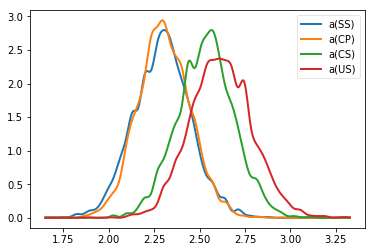

In [62]:
a_SS, a_CP, a_CS, a_US = pilot_model_threshold.nodes_db.node[['a(SS)', 'a(CP)', 'a(CS)', 'a(US)']]

hddm.analyze.plot_posterior_nodes([a_SS, a_CP, a_CS, a_US])

In [63]:
print('P(SS > US) = ' + str((a_SS.trace() > a_US.trace()).mean()))
print('P(CP > SS) = ' + str((a_CP.trace() > a_SS.trace()).mean()))
print('P(CS > SS) = ' + str((a_CS.trace() > a_SS.trace()).mean()))
print('P(CP > CS) = ' + str((a_CP.trace() > a_CS.trace()).mean()))
print('P(CS > US) = ' + str((a_CS.trace() > a_US.trace()).mean()))

P(SS > US) = 0.0605351170569
P(CP > SS) = 0.517725752508
P(CS > SS) = 0.87474916388
P(CP > CS) = 0.129598662207
P(CS > US) = 0.338461538462


No significant differences in threshold found across the different groups.